In [1]:
# Import dependancies
from bs4 import BeautifulSoup as bs
from splinter import Browser
import requests
import csv
import pandas as pd
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import datetime as dt
import matplotlib.pyplot as plt

### Get Vaccine Data from CDC

In [2]:
# Get Vaccinations Table from CDC website
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)
browser.visit("https://covid.cdc.gov/covid-data-tracker/#vaccinations")
vaccine_html = browser.html
browser.click_link_by_id("vaccinations-table-toggle")
cdc_html = browser.html
cdc_parsed = bs(cdc_html, "html.parser")
table = cdc_parsed.select("table")
browser.quit()

[WDM] - Current google-chrome version is 90.0.4430
[WDM] - Get LATEST driver version for 90.0.4430
[WDM] - Get LATEST driver version for 90.0.4430


[WDM] - Trying to download new driver from http://chromedriver.storage.googleapis.com/90.0.4430.24/chromedriver_win32.zip
[WDM] - Driver has been saved in cache [C:\Users\coled\.wdm\drivers\chromedriver\win32\90.0.4430.24]


In [3]:
# Read the CDC Vaccine HTML Table
vaccines_df = pd.read_html(str(table))[0]

In [4]:
# Change "New York State" to "New York" for data merging
vaccines_df.loc[vaccines_df["State/Territory/Federal Entity"] == "New York State", "State/Territory/Federal Entity"] = "New York"

In [5]:
# Rename "State/Territory/Federal Entity" column to "state" for data merging
vaccines_df = vaccines_df.rename(columns={"State/Territory/Federal Entity": "state"})

## Daily COVID-19 - NYT / Rearc

In [6]:
# Read Daily COVID-19 CSV from AWS S3 Bucket - Rearc / NY Times Data 
us_covid_cases_data = requests.get("https://covid19-lake.s3.us-east-2.amazonaws.com/rearc-covid-19-nyt-data-in-usa/csv/us-states/us-states.csv", stream=True)

In [7]:
# Overwrite the US COVID Data CSV with the latest one 
with open("../data/us-covid-data.csv",  "wb") as file:
    file.write(us_covid_cases_data.content)

In [8]:
# Read US COVID Data CSV for data merging and cleaning 
us_covid_cases_df = pd.read_csv("../data/us-covid-data.csv")

# State Overview Data

In [9]:
# Get yesterday's date, which is the latest data 
today = dt.date.today()
yesterday = today - dt.timedelta(days = 1)
latest_data = yesterday.strftime("%Y-%m-%d")

In [10]:
# Get latest total cases by state for latest date
us_total_cases_to_date_df = us_covid_cases_df.groupby(["date", "state"]).sum()
us_total_cases_to_date_df.reset_index(inplace=True)
us_total_cases_to_date_df = us_total_cases_to_date_df.loc[us_total_cases_to_date_df["date"] == latest_data]

In [11]:
# Read State Lat-Lon CSV and rename columns for easier cleaning and merging
state_latlons_df = pd.read_csv("../data/statelatlong.csv")
state_latlons_df.rename(columns={"State": "abbr", "Latitude": "lat", "Longitude": "lon", "City": "state"}, inplace=True)

In [12]:
# Read State Population CSV for cleaning and merging
state_pop_df = pd.read_csv("../data/state_populations_cleaned.csv")

In [13]:
# Merge, rename, and focus on defined columns
state_overview_master_df = pd.merge(state_pop_df, state_latlons_df, how="inner", on="state")
state_overview_master_df = state_overview_master_df[["state", "abbr", "lat", "lon", "population"]]

In [14]:
# Merge with us_total_cases_to_date_df and focus on defined columns
state_overview_master_df = pd.merge(state_overview_master_df, us_total_cases_to_date_df, how="inner", on="state")
state_overview_master_df = state_overview_master_df[["date", "state", "abbr", "lat", "lon", "population", "fips", "cases", "deaths"]]

In [15]:
# Merge with Vaccination data, rename columns, focus data columns
state_overview_master_df = pd.merge(state_overview_master_df, vaccines_df, how="inner", on="state")
state_overview_master_df = state_overview_master_df.rename(columns={"Total Doses Administered by State where Administered": "total_doses_administered", "Doses Administered per 100k by State where Administered": "doses_administered_per_100k"})
state_overview_master_df = state_overview_master_df[["date", "state", "abbr", "lat", "lon", "population", "fips", "cases", "deaths", "total_doses_administered", "doses_administered_per_100k"]]

In [16]:
# Add Empty Column for New Calculation
state_overview_master_df["percent_vaccinated"] = ""

In [17]:
# Calcuation for percent vaccinated by state
for index, row in state_overview_master_df.iterrows():
    population = row["population"]
    vaccinated = row["total_doses_administered"]
    percent_vaccinated = round((vaccinated / population) * 100, 2)
    
    state_overview_master_df.at[index, "percent_vaccinated"] = percent_vaccinated

In [18]:
# Convert percent vaccinated into a float
state_overview_master_df = state_overview_master_df.astype({"percent_vaccinated": 'float64'})

In [19]:
state_overview_master_df.to_csv("../data/state-master-data.csv")

In [20]:
state_overview_master_df["date"] = pd.to_datetime(state_overview_master_df["date"])

# County Overview Data

In [21]:
populations_county = pd.read_csv("../data/census-bureau-population-by-county.csv")
poverty_county = pd.read_csv("../data/poverty-and-median-household-income-data-by-us-county-2019.csv")
state_keys = pd.read_csv("../data/state-names-codes.csv")

In [22]:
poverty_county = poverty_county[["Postal Code", "county", "Poverty Estimate, All Ages", "Median Household Income"]]
poverty_county = poverty_county.rename(columns={"Postal Code": "code", "Poverty Estimate, All Ages": "poverty_est_all_ages", 
                                              "Median Household Income": "median_household_income"})
poverty_county["county"] = poverty_county["county"].str.rstrip()

In [23]:
state_keys = state_keys.rename(columns={"Code": "code", "State": "state"})
state_keys = state_keys[["state", "code"]]

In [24]:
poverty_county = pd.merge(poverty_county, state_keys, how="inner", on="code")
poverty_county.drop(columns={"state"}, inplace=True)

In [25]:
populations_county = populations_county.merge(state_keys, how="inner", on="state")
populations_county = populations_county[["code", "county", "state", "population_est"]]
populations_county["code"] = populations_county["code"].str.rstrip()
populations_county["county"] = populations_county["county"].str.rstrip()

In [26]:
merged_data = populations_county.merge(poverty_county, how='inner', left_on=["code", "county"], right_on=["code", "county"])

In [27]:
merged_data.dropna(how="any", inplace=True)

In [28]:
merged_data

,code,county,state,population_est,poverty_est_all_ages,median_household_income
0,AL,Alabama,Alabama,4903185,747478,51771
1,AL,Autauga,Alabama,55869,6723,58233
2,AL,Baldwin,Alabama,223234,22360,59871
3,AL,Barbour,Alabama,24686,5909,35972
4,AL,Bibb,Alabama,22394,4101,47918
...,...,...,...,...,...,...
3192,WY,Sweetwater,Wyoming,42343,3453,80639
3193,WY,Teton,Wyoming,23464,1396,98837
3194,WY,Uinta,Wyoming,20226,1699,70756
3195,WY,Washakie,Wyoming,7805,845,55122


### Retrieve County Cases Data

In [29]:
county_cases = requests.get("https://covid19-lake.s3.us-east-2.amazonaws.com/rearc-covid-19-nyt-data-in-usa/csv/us-counties/us-counties.csv", stream=True)

In [30]:
# Overwrite the US COVID Data CSV with the latest one 
with open("../data/county-covid-data.csv",  "wb") as file:
    file.write(county_cases.content)

In [31]:
# Read US COVID Data CSV for data merging and cleaning 
us_county_cases = pd.read_csv("../data/county-covid-data.csv")

In [32]:
us_county_cases = us_county_cases.groupby(["date", "state", "county"]).sum()
us_county_cases.reset_index(inplace=True)

In [33]:
us_county_cases = us_county_cases.merge(merged_data, how="left")

In [34]:
us_county_cases.to_csv("../data/county-cases-daily-master.csv")

In [35]:
us_county_cases["date"] = pd.to_datetime(us_county_cases["date"])

In [36]:
latest_covid_cases = us_county_cases.loc[us_county_cases["date"] == latest_data]

In [37]:
latest_covid_cases.dropna(how="any", inplace=True)

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
for index, row in latest_covid_cases.iterrows():
    latest_covid_cases.at[index, "poverty_est_all_ages"] = row["poverty_est_all_ages"].replace('.', "0")
    latest_covid_cases.at[index, "median_household_income"] = row["median_household_income"].replace('.', "0")

In [39]:
latest_covid_cases.fillna(0, inplace=True)

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [40]:
latest_covid_cases["poverty_est_all_ages"] = latest_covid_cases["poverty_est_all_ages"].astype('int64')
latest_covid_cases["median_household_income"] = latest_covid_cases["median_household_income"].astype('int64')

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
education_data = pd.read_csv("../data/county-level-education-stats-2015-2019.csv")

In [42]:
education_data.rename(columns={"state": "code"}, inplace=True)

In [43]:
education_data["county"] = education_data["county"].str.rstrip()

In [44]:
latest_covid_cases = latest_covid_cases.merge(education_data, how='outer', left_on=["code", "county"], right_on=["code", "county"])

In [45]:
latest_covid_cases.dropna(inplace=True)

In [46]:
for index, row in latest_covid_cases.iterrows():
    cases_per_100k = round((row["cases"] / row["population_est"]) * 100000)
    
    latest_covid_cases.at[index, "cases_per_100k"] = cases_per_100k

In [47]:
latest_covid_cases.to_csv("../data/county-cases-latest-master.csv")

## Daily Cases

In [48]:
daily_vaccinations = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv")

In [49]:
daily_vaccs_cleaned = daily_vaccinations[["date", "location", "people_fully_vaccinated"]]

In [50]:
daily_vaccs_cleaned["date"] = pd.to_datetime(daily_vaccs_cleaned["date"])

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
daily_vaccs_cleaned.rename(columns={"location": "state"}, inplace=True)

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [52]:
# Convert Dates to pd.Datetimes
us_covid_cases_df["date"] = pd.to_datetime(us_covid_cases_df["date"])

In [53]:
us_covid_cases_df

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
22889,2021-04-22,Virginia,51,650981,10653
22890,2021-04-22,Washington,53,393514,5472
22891,2021-04-22,West Virginia,54,150288,2808
22892,2021-04-22,Wisconsin,55,654681,7438


In [54]:
us_covid_cases_df = us_covid_cases_df.merge(daily_vaccs_cleaned, how="left", left_on=["date", "state"], right_on=["date", "state"])

In [55]:
us_covid_cases_df.fillna(0, inplace=True)

In [56]:
# Create Daily New Cases Dataframe
daily_new_cases_df = us_covid_cases_df.groupby("date").sum()

In [57]:
daily_new_cases_df["daily_new_fully_vaccinated"] = ""

In [58]:
# daily_new_cases_df[daily_new_cases_df["people_fully_vaccinated"] != 0]
previous_day_vaccinations = 0

for index, row in daily_new_cases_df.iterrows():
    
#     if row["people_fully_vaccinated"] == 0:
#         previous_day_vaccinations = 0
#         new_vaccinations = row["people_fully_vaccinated"] - previous_day_vaccinations
#         daily_new_cases_df.at[index, "daily_new_fully_vaccinated"] = new_vaccinations
#     else:

    if row["people_fully_vaccinated"] == 0:
        new_vaccinations = row["people_fully_vaccinated"]
        daily_new_cases_df.at[index, "daily_new_fully_vaccinated"] = new_vaccinations
        
    else:
        new_vaccinations = row["people_fully_vaccinated"] - previous_day_vaccinations
        previous_day_vaccinations = row["people_fully_vaccinated"]
        daily_new_cases_df.at[index, "daily_new_fully_vaccinated"] = new_vaccinations
    
#     daily_new_cases_df.at[index, "daily_new_fully_vaccinated"] = new_vaccinations

In [59]:
daily_new_cases_df.reset_index(inplace=True)

In [60]:
daily_new_cases_df[daily_new_cases_df["date"] > dt.datetime(2021, 2, 10)]

,date,fips,cases,deaths,people_fully_vaccinated,daily_new_fully_vaccinated
387,2021-02-11,1762,27435423,475238,9915475.0,630731
388,2021-02-12,1762,27534975,480701,10714726.0,799251
389,2021-02-13,1762,27619754,484073,11606347.0,891621
390,2021-02-14,1762,27683598,485154,12486790.0,880443
391,2021-02-15,1762,27738965,486148,0.0,0
...,...,...,...,...,...,...
453,2021-04-18,1762,31691021,566806,78087184.0,1.66626e+06
454,2021-04-19,1762,31761408,567291,79111660.0,1.02448e+06
455,2021-04-20,1762,31822125,568123,79895779.0,784119
456,2021-04-21,1762,31885044,568962,81181418.0,1.28564e+06


In [61]:
# Add new Empty Columns for Daily New Cases and Deaths
daily_new_cases_df["daily_new_cases"] = ""
daily_new_cases_df["daily_new_deaths"] = ""

In [62]:
previous_day_cases = 0
previous_day_deaths = 0
    
for index, row in daily_new_cases_df.iterrows():
    
    # Cases
    new_cases = row["cases"] - previous_day_cases
    previous_day_cases = row["cases"]
    daily_new_cases_df.at[index, "daily_new_cases"] = new_cases
    
    # Deaths
    new_deaths = row["deaths"] - previous_day_deaths
    previous_day_deaths = row["deaths"]
    daily_new_cases_df.at[index, "daily_new_deaths"] = new_deaths

In [63]:
daily_new_cases_df

,date,fips,cases,deaths,people_fully_vaccinated,daily_new_fully_vaccinated,daily_new_cases,daily_new_deaths
0,2020-01-21,53,1,0,0.0,0,1,0
1,2020-01-22,53,1,0,0.0,0,0,0
2,2020-01-23,53,1,0,0.0,0,0,0
3,2020-01-24,70,2,0,0.0,0,1,0
4,2020-01-25,76,3,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...
453,2021-04-18,1762,31691021,566806,78087184.0,1.66626e+06,41612,358
454,2021-04-19,1762,31761408,567291,79111660.0,1.02448e+06,70387,485
455,2021-04-20,1762,31822125,568123,79895779.0,784119,60717,832
456,2021-04-21,1762,31885044,568962,81181418.0,1.28564e+06,62919,839


In [64]:
daily_new_cases_df["new_cases_shift"] = daily_new_cases_df["daily_new_cases"].shift(periods=14)
daily_new_cases_df.fillna(0, inplace=True)

In [65]:
daily_new_cases_df["3_month_immunity_est"] = daily_new_cases_df["new_cases_shift"].rolling(90).sum()

In [66]:
daily_new_cases_df

,date,fips,cases,deaths,people_fully_vaccinated,daily_new_fully_vaccinated,daily_new_cases,daily_new_deaths,new_cases_shift,3_month_immunity_est
0,2020-01-21,53,1,0,0.0,0.0,1,0,0,NaN
1,2020-01-22,53,1,0,0.0,0.0,0,0,0,NaN
2,2020-01-23,53,1,0,0.0,0.0,0,0,0,NaN
3,2020-01-24,70,2,0,0.0,0.0,1,0,0,NaN
4,2020-01-25,76,3,0,0.0,0.0,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
453,2021-04-18,1762,31691021,566806,78087184.0,1666260.0,41612,358,36902,9812392.0
454,2021-04-19,1762,31761408,567291,79111660.0,1024476.0,70387,485,76855,9654220.0
455,2021-04-20,1762,31822125,568123,79895779.0,784119.0,60717,832,62003,9460224.0
456,2021-04-21,1762,31885044,568962,81181418.0,1285639.0,62919,839,73083,9253003.0


In [67]:
daily_new_cases_df["6_month_immunity_est"] = daily_new_cases_df.rolling(180)["new_cases_shift"].sum()

In [68]:
daily_new_cases_df = daily_new_cases_df.fillna(0)

<AxesSubplot:>

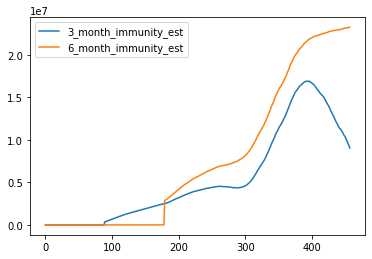

In [69]:
daily_new_cases_df[["3_month_immunity_est", "6_month_immunity_est"]].plot()

In [70]:
for index, row in daily_new_cases_df.iterrows():
    
    # 3-month immunity
    recovered = row["3_month_immunity_est"]
    fully_vaccinated = row["people_fully_vaccinated"]
    
    daily_new_cases_df.at[index, "3_month_immunity_est"] = recovered + fully_vaccinated
    
    # 6-month immunity
    six_recovered = row["6_month_immunity_est"]
    
    daily_new_cases_df.at[index, "6_month_immunity_est"] = six_recovered + fully_vaccinated

In [71]:
daily_new_cases_df[daily_new_cases_df["date"] == dt.datetime(2021, 2, 16)]

,date,fips,cases,deaths,people_fully_vaccinated,daily_new_fully_vaccinated,daily_new_cases,daily_new_deaths,new_cases_shift,3_month_immunity_est,6_month_immunity_est
392,2021-02-16,1762,27803366,487855,13303348.0,816558.0,64401,1707,117929,30203428.0,34889564.0


In [72]:
daily_new_cases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        458 non-null    datetime64[ns]
 1   fips                        458 non-null    int64         
 2   cases                       458 non-null    int64         
 3   deaths                      458 non-null    int64         
 4   people_fully_vaccinated     458 non-null    float64       
 5   daily_new_fully_vaccinated  458 non-null    float64       
 6   daily_new_cases             458 non-null    int64         
 7   daily_new_deaths            458 non-null    int64         
 8   new_cases_shift             458 non-null    int64         
 9   3_month_immunity_est        458 non-null    float64       
 10  6_month_immunity_est        458 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(6)
memory usage: 3

In [73]:
daily_new_cases_df.to_csv("../data/state-daily-stats.csv")

## Amazon RDS Updates

In [74]:
# Config Variables, and SQLalchemy
from config import endpoint, username, password
from sqlalchemy import create_engine

In [75]:
# Connect to AWS Database instance 
engine = create_engine(f'postgresql://uscovid:{password}@{endpoint}/us_covid_db')
connection = engine.connect()
# connection = psycopg2.connect(database=heroku_dbname, user=hreoku_username, password=hreoku_password, host="ec2-34-230-167-186.compute-1.amazonaws.com", port="5432", sslmode='require')

In [76]:
# 50 States & D.C. Data
state_overview_master_df.to_sql('master_table', index=False, if_exists='replace', con=connection)
engine.execute('ALTER TABLE master_table ADD PRIMARY KEY (state);')

In [77]:
# Daily Cases Data
daily_new_cases_df.to_sql("daily_new_cases", index=False, if_exists='replace', con=connection)
engine.execute('ALTER TABLE daily_new_cases ADD PRIMARY KEY (date);')

In [78]:
# County Data
latest_covid_cases.to_sql("county_cases_latest", index=True, if_exists='replace', con=connection)
engine.execute('ALTER TABLE county_cases_latest ADD PRIMARY KEY (index);')

In [79]:
# Raw NTY Data
us_covid_cases_df.to_sql('nyt_table', index=True, if_exists='replace', con=connection)
engine.execute('ALTER TABLE nyt_table ADD PRIMARY KEY (index);')